In [2]:
import sys
sys.path.append("../scripts")


import data
import utils
import experiments
from models import dual_obj_1, get_subgroup_indicator, logloss_group, logloss_grad, logloss_hessian, logloss_group_grad, logloss_group_hess, FairGBMClassifier, LGBMClassifier


import numpy as np
import pandas as pd
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper functions

In [3]:
import lightgbm as lgb
lgb.register_logger(utils.CustomLogger())

In [4]:
def projection_to_simplex(mu, z = 1):
    sorted_mu = mu[np.argsort(mu)]
    n = len(mu)
    t =  np.mean(mu) - z / n
    for i in range(len(mu) - 2, -1, -1):
        t_i = np.mean(sorted_mu[(i+1):]) - z / (n - i - 1)
        if t_i >= sorted_mu[i]:
            t = t_i
            break

    x = mu - t
    x = np.where(x > 0, x, 0)
    return x

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class M2FGB(BaseEstimator, ClassifierMixin):
    """Classifier that modifies LGBM to incorporate min-max fairness optimization.
    It shares many of the parameters with LGBM to control learning and decision trees.
    The fairness metrics impelemented are "equalized_loss", "equal_opportunity", and "demographic_parity".
    
    Parameters
    ----------
    fairness_constraint : str, optional
        Fairness constraint used in learning, must be ["equalized_loss", "equal_opportunity", "demographic_parity"], by default "equalized_loss"
    fair_weight : int, optional
        Weight for fairness in loss formulation, by default 1
    dual_learning : str, optional
        Method used to learn the dual problem, must be ["optim", "grad"], by default "optim"
    multiplier_learning_rate: float, optional
        Learning rate used in the gradient learning of the dual, used only if dual_learning="gradient", by default 0.1
    n_estimators : int, optional
        Number of estimators used in XGB, by default 10
    learning_rate : float, optional
        Learning rate of ensambles, by default 0.1
    max_depth : int, optional
        Max depth of decision trees, by default 6
    min_child_weight : int, optional
        Weight used to choose partition of tree nodes, by default 1
    reg_lambda : int, optional
        Weight of L2 regularization, by default 1
    random_state : int, optional
        Random seed used in learning, by default None
    """

    def __init__(
        self,
        fairness_constraint="equalized_loss",
        fair_weight=1,
        dual_learning="optim",
        multiplier_learning_rate=0.1,
        n_estimators=10,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        reg_lambda=1,
        random_state=None,
    ):
        assert fairness_constraint in [
            "equalized_loss",
            "equal_opportunity",
            "demographic_parity",
        ]
        assert dual_learning in ["optim", "gradient"]

        self.fairness_constraint = fairness_constraint
        self.dual_learning = dual_learning
        self.multiplier_learning_rate = multiplier_learning_rate
        self.fair_weight = fair_weight
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.reg_lambda = reg_lambda
        self.random_state = random_state
        

    def fit(self, X, y, sensitive_attribute):
        """Fit the model to the data.

        Parameters
        ----------
        X : pandas.DataFrame
            Dataframe of shape (n_samples, n_features)
        y : pandas.Series or numpy.ndarray
            Labels array-like of shape (n_samples), must be (0 or 1)
        sensitive_attribute : pandas.Series or numpy.ndarray
            Sensitive attribute array-like of shape (n_samples)

        Returns
        -------
        M2FGB
            Fitted model
        """
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.group_losses = []
        self.mu_opt_list = [None]
        dtrain = lgb.Dataset(X, label=y)

        params = {
            "objective": dual_obj_1(
                sensitive_attribute,
                self.fair_weight,
                self.group_losses,
                self.mu_opt_list,
                self.fairness_constraint,
                self.dual_learning,
                self.multiplier_learning_rate,
            ),
            "learning_rate": self.learning_rate,
            "max_depth": self.max_depth,
            "min_child_weight": self.min_child_weight,
            "reg_lambda": self.reg_lambda,
            "verbose": -1,
        }
        if self.random_state is not None:
            params["random_seed"] = self.random_state

        self.model_ = lgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
        )
        self.group_losses = np.array(self.group_losses)
        self.mu_opt_list = np.array(self.mu_opt_list)
        return self

    def predict(self, X):
        """Predict the labels of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds = 1 / (1 + np.exp(-log_odds))
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        """Predict the probabilities of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds_pos = 1 / (1 + np.exp(-log_odds))
        preds = np.ones((preds_pos.shape[0], 2))
        preds[:, 1] = preds_pos
        preds[:, 0] -= preds_pos
        return preds


In [6]:
def get_subgroup_indicator_test(subgroup):
    groups = np.unique(subgroup)
    n = len(subgroup)
    I = np.zeros((subgroup.shape[0], len(groups)))
    n_g_max = -np.inf
    for i, g in enumerate(groups):
        n_g = np.sum(subgroup == g)
        n_g_max = max(n_g_max, n_g)
        I[subgroup == g, i] = 1 / np.sum(subgroup == g)   
    
    I = I * n
    return I

In [7]:
def logloss_group_test(predt, dtrain, subgroup, fairness_constraint):
    """For each subgroup, calculates the mean log loss of the samples."""
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    predt = np.clip(predt, 1e-7, 1 - 1e-7)  # avoid log(0)
    if fairness_constraint == "equalized_loss":
        loss = -(y * np.log(predt) + (1 - y) * np.log(1 - predt))
    if fairness_constraint == "demographic_parity":
        y_ = np.ones(y.shape[0])  # all positive class
        loss = -(y_ * np.log(predt) + (1 - y_) * np.log(1 - predt))
    elif fairness_constraint == "equal_opportunity":
        loss = -(y * np.log(predt) + (1 - y) * np.log(1 - predt))
        loss[y == 0] = 0  # only consider the loss of the positive class

    loss = np.array([np.mean(loss[subgroup == g]) for g in np.unique(subgroup)])
    return loss

def logloss_group_grad_test(predt, dtrain, fairness_constraint):
    """Create a matrix with the gradient for each subgroup in each column."""
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    if fairness_constraint == "equalized_loss":
        grad = -(y - predt)
    elif fairness_constraint == "demographic_parity":
        y_ = np.ones(y.shape[0])  # all positive class
        grad = -(y_ - predt)
    elif fairness_constraint == "equal_opportunity":
        grad = -(y - predt)
        grad[y == 0] = 0  # only consider the loss of the positive class

    return grad


def logloss_group_hess_test(predt, dtrain, fairness_constraint):
    """Create a matrix with the hessian for each subgroup in each column."""
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    if fairness_constraint == "equalized_loss":
        hess = predt * (1 - predt)
    elif (
        fairness_constraint == "demographic_parity"
        or fairness_constraint == "equal_opportunity"
    ):
        hess = predt * (1 - predt)
        hess[y == 0] = 0  # only consider the loss of the positive class
    
    return hess


def dual_obj_test(
    subgroup,
    group_losses,
    mu_opt_list,
    fairness_constraint="equalized_loss",
    dual_learning="optim",
    multiplier_learning_rate=0.1,
):
    I = get_subgroup_indicator_test(subgroup)

    def custom_obj(predt, dtrain):
        loss_group = logloss_group_test(predt, dtrain, subgroup, fairness_constraint)
        if len(mu_opt_list) > 1:
            group_losses.append(loss_group)
        
        if dual_learning == "optim":
            # dual problem solved analytically
            idx_biggest_loss = np.where(loss_group == np.max(loss_group))[0]
            # if is more than one, randomly choose one
            idx_biggest_loss = np.random.choice(idx_biggest_loss)
            mu_opt = np.zeros(loss_group.shape[0])
            mu_opt[idx_biggest_loss] = 1
            if mu_opt_list[0] is None:
                mu_opt_list[0] = mu_opt
            else:
                mu_opt_list.append(mu_opt)

        elif dual_learning == "gradient":
            if mu_opt_list[0] is None:
                mu_opt = np.zeros(loss_group.shape[0])
                mu_opt_list[0] = mu_opt

            else:
                mu_opt = mu_opt_list[-1].copy()
                mu_opt += multiplier_learning_rate * loss_group
                mu_opt_list.append(mu_opt)

        elif dual_learning == "gradient_norm":
            if mu_opt_list[0] is None:
                mu_opt = np.ones(loss_group.shape[0])
                mu_opt = mu_opt / np.sum(mu_opt)
                mu_opt_list[0] = mu_opt

            else:
                mu_opt = mu_opt_list[-1].copy()
                mu_opt += multiplier_learning_rate * loss_group
                mu_opt = projection_to_simplex(mu_opt)
                mu_opt_list.append(mu_opt)


        grad = logloss_group_grad_test(predt, dtrain, fairness_constraint)
        grad = I * grad.reshape(-1, 1) @ mu_opt

        hess = logloss_group_hess_test(predt, dtrain, fairness_constraint)
        hess = I * hess.reshape(-1, 1) @ mu_opt

        return grad, hess

    return custom_obj



class M2FGB_test(BaseEstimator, ClassifierMixin):
    """Classifier that modifies LGBM to incorporate min-max fairness optimization.
    It shares many of the parameters with LGBM to control learning and decision trees.
    The fairness metrics impelemented are "equalized_loss", "equal_opportunity", and "demographic_parity".
    
    Parameters
    ----------
    fairness_constraint : str, optional
        Fairness constraint used in learning, must be ["equalized_loss", "equal_opportunity", "demographic_parity"], by default "equalized_loss"
    fair_weight : int, optional
        Weight for fairness in loss formulation, by default 1
    dual_learning : str, optional
        Method used to learn the dual problem, must be ["optim", "grad"], by default "optim"
    multiplier_learning_rate: float, optional
        Learning rate used in the gradient learning of the dual, used only if dual_learning="gradient", by default 0.1
    n_estimators : int, optional
        Number of estimators used in XGB, by default 10
    learning_rate : float, optional
        Learning rate of ensambles, by default 0.1
    max_depth : int, optional
        Max depth of decision trees, by default 6
    min_child_weight : int, optional
        Weight used to choose partition of tree nodes, by default 1
    reg_lambda : int, optional
        Weight of L2 regularization, by default 1
    random_state : int, optional
        Random seed used in learning, by default None
    """

    def __init__(
        self,
        fairness_constraint="equalized_loss",
        dual_learning="optim",
        multiplier_learning_rate=0.1,
        n_estimators=10,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        reg_lambda=1,
        random_state=None,
    ):
        assert fairness_constraint in [
            "equalized_loss",
            "equal_opportunity",
            "demographic_parity",
        ]
        assert dual_learning in ["optim", "gradient", "gradient_norm"]

        self.fairness_constraint = fairness_constraint
        self.dual_learning = dual_learning
        self.multiplier_learning_rate = multiplier_learning_rate
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.reg_lambda = reg_lambda
        self.random_state = random_state
        

    def fit(self, X, y, sensitive_attribute):
        """Fit the model to the data.

        Parameters
        ----------
        X : pandas.DataFrame
            Dataframe of shape (n_samples, n_features)
        y : pandas.Series or numpy.ndarray
            Labels array-like of shape (n_samples), must be (0 or 1)
        sensitive_attribute : pandas.Series or numpy.ndarray
            Sensitive attribute array-like of shape (n_samples)

        Returns
        -------
        M2FGB
            Fitted model
        """
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.group_losses = []
        self.mu_opt_list = [None]
        dtrain = lgb.Dataset(X, label=y)

        params = {
            "objective": dual_obj_test(
                sensitive_attribute,
                self.group_losses,
                self.mu_opt_list,
                self.fairness_constraint,
                self.dual_learning,
                self.multiplier_learning_rate,
            ),
            "learning_rate": self.learning_rate,
            "max_depth": self.max_depth,
            "min_child_weight": self.min_child_weight,
            "reg_lambda": self.reg_lambda,
            "verbose": -1,
        }
        if self.random_state is not None:
            params["random_seed"] = self.random_state

        self.model_ = lgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
        )
        self.group_losses = np.array(self.group_losses)
        self.mu_opt_list = np.array(self.mu_opt_list)
        return self

    def predict(self, X):
        """Predict the labels of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds = 1 / (1 + np.exp(-log_odds))
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        """Predict the probabilities of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds_pos = 1 / (1 + np.exp(-log_odds))
        preds = np.ones((preds_pos.shape[0], 2))
        preds[:, 1] = preds_pos
        preds[:, 0] -= preds_pos
        return preds

In [9]:
def dual_obj_new(
    subgroup,
    fair_weight,
    group_losses,
    mu_opt_list,
    fairness_constraint="equalized_loss",
    dual_learning="optim",
    multiplier_learning_rate=0.1,
):
    I = get_subgroup_indicator_test(subgroup)

    def custom_obj(predt, dtrain):
        loss_group = logloss_group_test(predt, dtrain, subgroup, fairness_constraint)
        if len(mu_opt_list) > 1:
            group_losses.append(loss_group)
        
        if dual_learning == "optim":
            # dual problem solved analytically
            idx_biggest_loss = np.where(loss_group == np.max(loss_group))[0]
            # if is more than one, randomly choose one
            idx_biggest_loss = np.random.choice(idx_biggest_loss)
            mu_opt = np.zeros(loss_group.shape[0])
            mu_opt[idx_biggest_loss] = fair_weight
            if mu_opt_list[0] is None:
                mu_opt_list[0] = mu_opt
            else:
                mu_opt_list.append(mu_opt)

        elif dual_learning == "gradient":
            if mu_opt_list[0] is None:
                mu_opt = np.zeros(loss_group.shape[0])
                mu_opt_list[0] = mu_opt

            else:
                mu_opt = mu_opt_list[-1].copy()
                mu_opt += fair_weight * multiplier_learning_rate * loss_group
                mu_opt_list.append(mu_opt)

        elif dual_learning == "gradient_norm":
            if mu_opt_list[0] is None:
                mu_opt = np.ones(loss_group.shape[0])
                mu_opt = projection_to_simplex(mu_opt, z=fair_weight)
                mu_opt_list[0] = mu_opt

            else:
                mu_opt = mu_opt_list[-1].copy()
                mu_opt += multiplier_learning_rate * loss_group
                mu_opt = projection_to_simplex(mu_opt, z=fair_weight)
                mu_opt_list.append(mu_opt)


        grad_fair = logloss_group_grad_test(predt, dtrain, fairness_constraint)
        grad_fair = I * grad_fair.reshape(-1, 1) @ mu_opt

        hess_fair = logloss_group_hess_test(predt, dtrain, fairness_constraint)
        hess_fair = I * hess_fair.reshape(-1, 1) @ mu_opt

        grad = logloss_grad(predt, dtrain)
        hess = logloss_hessian(predt, dtrain)


        #grad = (1 - fair_weight) * grad + fair_weight * grad_fair
        #hess = (1 - fair_weight) * hess + fair_weight * hess_fair

        grad = (1 - fair_weight) * grad + grad_fair
        hess = (1 - fair_weight) * hess + hess_fair

        return grad, hess

    return custom_obj


class M2FGB_new(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        fairness_constraint="equalized_loss",
        fair_weight = 0.5,
        dual_learning="optim",
        multiplier_learning_rate=0.1,
        n_estimators=10,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        reg_lambda=1,
        random_state=None,
    ):
        assert fairness_constraint in [
            "equalized_loss",
            "equal_opportunity",
            "demographic_parity",
        ]
        assert dual_learning in ["optim", "gradient", "gradient_norm"]

        self.fairness_constraint = fairness_constraint
        self.fair_weight = fair_weight
        self.dual_learning = dual_learning
        self.multiplier_learning_rate = multiplier_learning_rate
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.reg_lambda = reg_lambda
        self.random_state = random_state
        

    def fit(self, X, y, sensitive_attribute):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.group_losses = []
        self.mu_opt_list = [None]
        dtrain = lgb.Dataset(X, label=y)

        params = {
            "objective": dual_obj_new(
                sensitive_attribute,
                self.fair_weight,
                self.group_losses,
                self.mu_opt_list,
                self.fairness_constraint,
                self.dual_learning,
                self.multiplier_learning_rate,
            ),
            "learning_rate": self.learning_rate,
            "max_depth": self.max_depth,
            "min_child_weight": self.min_child_weight,
            "reg_lambda": self.reg_lambda,
            "verbose": -1,
        }
        if self.random_state is not None:
            params["random_seed"] = self.random_state

        self.model_ = lgb.train(
            params,
            dtrain,
            num_boost_round=self.n_estimators,
        )
        self.group_losses = np.array(self.group_losses)
        self.mu_opt_list = np.array(self.mu_opt_list)
        return self

    def predict(self, X):
        """Predict the labels of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds = 1 / (1 + np.exp(-log_odds))
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        """Predict the probabilities of the data."""
        check_is_fitted(self)
        X = check_array(X)
        log_odds = self.model_.predict(X)
        preds_pos = 1 / (1 + np.exp(-log_odds))
        preds = np.ones((preds_pos.shape[0], 2))
        preds[:, 1] = preds_pos
        preds[:, 0] -= preds_pos
        return preds

In [10]:
def plot_model_result(model):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 5))

    x = np.arange(model.mu_opt_list.shape[0])
    for i in range(model.group_losses.shape[1]):
        axs[0].plot(x[2:], model.group_losses[:, i], label=f"Group {i}")
        axs[1].plot(x[3:], np.diff(model.group_losses[:, i]), label=f"Group {i}", alpha = 0.5)
        if len(np.unique(model.mu_opt_list)) == 2:
            axs[2].scatter(
                x, 
                model.mu_opt_list[:, i] + np.random.uniform(0, 0.1, model.mu_opt_list.shape[0]),
                label=f"Group {i}",
                alpha = 0.25
            )
            axs[2].set_title("$\mu + U(0, 0.1)$")
        else:
            axs[2].plot(x, model.mu_opt_list[:, i], label=f"Group {i}")
            axs[2].set_title("$\mu$")

    axs[0].set_title("Group logloss")
    axs[1].set_title("diff(Group logloss)")
    

    for i in range(3):
        axs[i].legend()
        axs[i].grid()
        axs[i].set_xlabel("Iteration")

    # get 10%-90% quantile range of the np.diff(model.group_losses)
    ndiff = np.concatenate([
        np.diff(model.group_losses[:, i]) for i in range(model.group_losses.shape[1])
    ])
    axs[1].set_ylim(np.quantile(ndiff, 0.05), np.quantile(ndiff, 0.95))

    plt.show()

In [11]:
def get_metrics(Y_target, Y_pred, A):
    metrics = {
        "bal_acc" : utils.balanced_accuracy_score(Y_target, Y_pred),
        "roc" : utils.roc_auc_score(Y_target, Y_pred),
        "eod" : utils.equal_opportunity_score(Y_target, Y_pred, A),
        "min_bal_acc" : 1 - utils.min_balanced_accuracy(Y_target, Y_pred, A),
    }
    return metrics

## Loading data

In [12]:
dataset = "adult"

In [13]:
X_train, Y_train, X_val, Y_val, X_test, Y_test =  data.get_fold(dataset, 3, 10, 0)
A_train, A_val, A_test = experiments.get_subgroup_feature(dataset, X_train, X_val, X_test, 4)

{'Male_True': 0, 'Male_False': 1, 'Female_False': 2, 'Female_True': 3}


In [14]:
col_trans = ColumnTransformer(
    [
        ("numeric", StandardScaler(), data.NUM_FEATURES[dataset]),
        (
            "categorical",
            OneHotEncoder(
                drop="if_binary", sparse_output=False, handle_unknown="ignore"
            ),
            data.CAT_FEATURES[dataset],
        ),
    ],
    verbose_feature_names_out=False,
)
col_trans.set_output(transform="pandas")

preprocess = Pipeline([("preprocess", col_trans)])
preprocess.fit(X_train)
X_train = preprocess.transform(X_train)
X_val = preprocess.transform(X_val)
X_test = preprocess.transform(X_test)

In [15]:
def run_trial(
    trial,
    scorer,
    X_train,
    Y_train,
    A_train,
    X_val,
    Y_val,
    A_val,
    model_class,
    param_space,
    args,
):
    """Function to run a single trial of optuna."""
    params = {}
    for name, values in param_space.items():
        if values["type"] == "int":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_int(name, **values_cp)
        elif values["type"] == "categorical":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_categorical(name, **values_cp)
        elif values["type"] == "float":  # corrected this line
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_float(name, **values_cp)

    model = model_class(**params)
    model.fit(X_train, Y_train, A_train)

    Y_val_score = model.predict_proba(X_val)[:, 1]
    if args["thresh"] == "ks":
        thresh = utils.get_best_threshold(Y_val, Y_val_score)
    else:
        thresh = 0.5
    Y_val_pred = Y_val_score > thresh
    return scorer(Y_val, Y_val_pred, A_val)

## Testing M²FGB with only fairness

In [13]:
model = M2FGB_test(n_estimators=500, min_child_weight=1, learning_rate = 0.1)
model.fit(X_train, Y_train, A_train)

M2FGB_test(n_estimators=500)

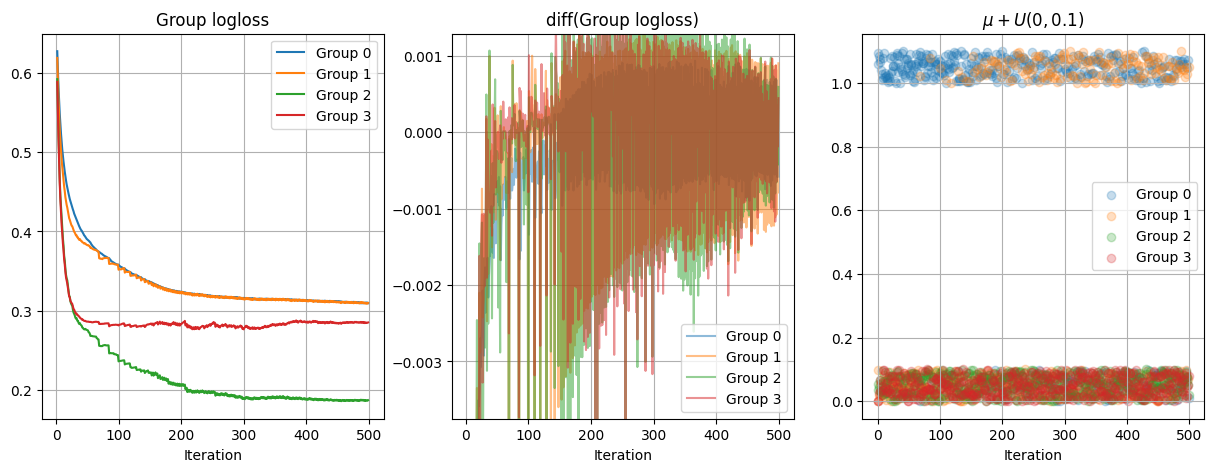

In [14]:
plot_model_result(model)

In [15]:
model = M2FGB_test(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient", multiplier_learning_rate = 0.1)
model.fit(X_train, Y_train, A_train)

M2FGB_test(dual_learning='gradient', n_estimators=500)

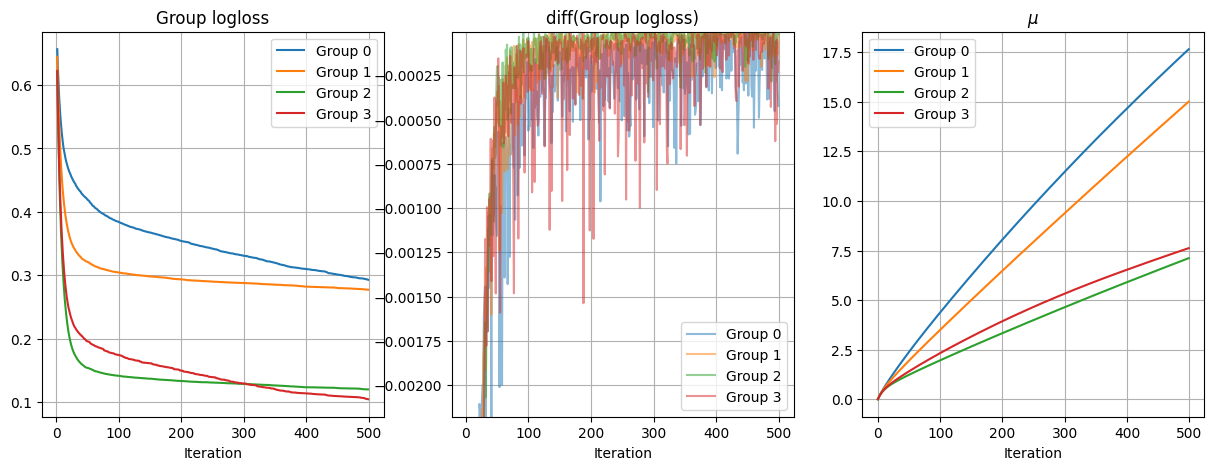

In [16]:
plot_model_result(model)

In [17]:
model = M2FGB_test(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient_norm", multiplier_learning_rate = 0.01)
model.fit(X_train, Y_train, A_train)

M2FGB_test(dual_learning='gradient_norm', multiplier_learning_rate=0.01,
           n_estimators=500)

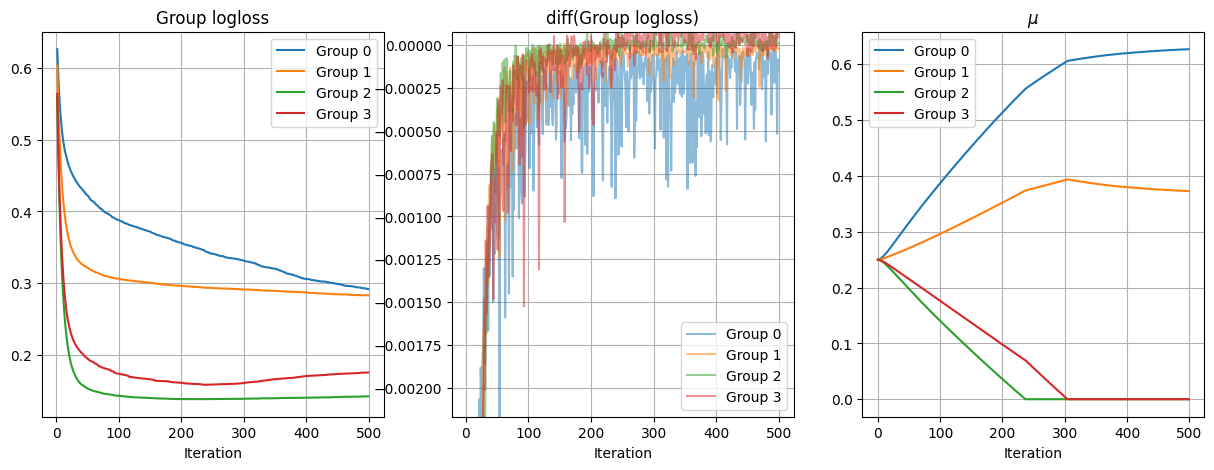

In [18]:
plot_model_result(model)

## Evaluate at some folder with hyper-param tuning

In [21]:
scorer = utils.get_combined_metrics_scorer(
    alpha=0., performance_metric="bal_acc", fairness_metric="min_bal_acc"
)

In [22]:
param_spaces = {}
for model_name in ["LGBMClassifier", "FairGBMClassifier"]:
    param_spaces[model_name] = experiments.get_param_spaces(model_name)
    #param_spaces[model_name]["n_estimators"] = {"type" : "int", "low" : 250, "high":250}
    #param_spaces[model_name]["learning_rate"] = {"type" : "float", "low" : 0.1, "high":0.1}

param_spaces["M2FGB_test"] = experiments.get_param_spaces("M2FGB").copy()
param_spaces["M2FGB_grad_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
param_spaces["M2FGB_grad_norm_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
del param_spaces["M2FGB_test"]["fair_weight"]
del param_spaces["M2FGB_grad_test"]["fair_weight"]
del param_spaces["M2FGB_grad_norm_test"]["fair_weight"]

In [24]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [28]:
best_params = {}
best_models = {}
results = []
for model_name in ["LGBMClassifier", "FairGBMClassifier", "M2FGB_test", "M2FGB_grad_test", "M2FGB_grad_norm_test"]:
    if model_name == "M2FGB_test":
        def model_(**params):
            return M2FGB_test(random_state=0, **params)
        model_class = model_
    elif model_name == "M2FGB_grad_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient", **params)
        model_class = model_
    elif model_name == "M2FGB_grad_norm_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient_norm", **params)
        model_class = model_
    else:
        model_class = experiments.get_model(model_name, random_state=0)

    study = optuna.create_study(direction="maximize")
    objective = lambda trial: run_trial(
        trial,
        scorer,
        X_train,
        Y_train,
        A_train,
        X_val,
        Y_val,
        A_val,
        model_class,
        param_spaces[model_name],
        {"thresh" : 0.5},
    )
    study.optimize(objective, n_trials=100, n_jobs=-1)
    best_params[model_name] = study.best_params.copy()

    model = model_class(**best_params[model_name])
    model.fit(X_train, Y_train, A_train)

    best_models[model_name] = model
    Y_train_pred = model.predict(X_train) > 0.5
    Y_val_pred = model.predict(X_val) > 0.5
    Y_test_pred = model.predict(X_test) > 0.5

    results.append(get_metrics(Y_train, Y_train_pred, A_train))
    results[-1]["set"] = "train"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_val, Y_val_pred, A_val))
    results[-1]["set"] = "val"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_test, Y_test_pred, A_test))
    results[-1]["set"] = "test"
    results[-1]["model"] = model_name


results = pd.DataFrame(results)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Wa

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow enc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objectiv

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No furt

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overfl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objectiv

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: over

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accu

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Accuracy may be bad since you didn't e

/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Using self-defined objective

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [29]:
results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))

/tmp/ipykernel_2216/3152775685.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))


bal_acc       roc       eod  min_bal_acc    set  \
set                                                          
test  5   0.820199  0.820199  0.111362     0.782580   test   
      2   0.807311  0.807311  0.150873     0.760135   test   
      11  0.808914  0.808914  0.154857     0.758205   test   
      14  0.793404  0.793404  0.253363     0.716299   test   
      8   0.795544  0.795544  0.227613     0.712838   test   
train 9   0.836692  0.836692  0.135204     0.817039  train   
      0   0.822036  0.822036  0.045593     0.802301  train   
      3   0.820092  0.820092  0.099904     0.781116  train   
      6   0.802254  0.802254  0.244246     0.724454  train   
      12  0.800762  0.800762  0.251470     0.713626  train   
val   4   0.806102  0.806102  0.098663     0.764592    val   
      1   0.797378  0.797378  0.141667     0.756840    val   
      7   0.790229  0.790229  0.131979     0.754245    val   
      13  0.792093  0.792093  0.174588     0.749292    val   
      10  0.799066  0.799066  0.214046     0.729953    val   

                         model  
set                             
test  5      FairGBMClassifier  
      2         LGBMClassifier  
      11       M2FGB_grad_test  
      14  M2FGB_grad_norm_test  
      8             M2FGB_test  
train 9        M2FGB_grad_test  
      0         LGBMClassifier  
      3      FairGBMClassifier  
      6             M2FGB_test  
      12  M2FGB_grad_norm_test  
val   4      FairGBMClassifier  
      1         LGBMClassifier  
      7             M2FGB_test  
      13  M2FGB_grad_norm_test  
      10       M2FGB_grad_test

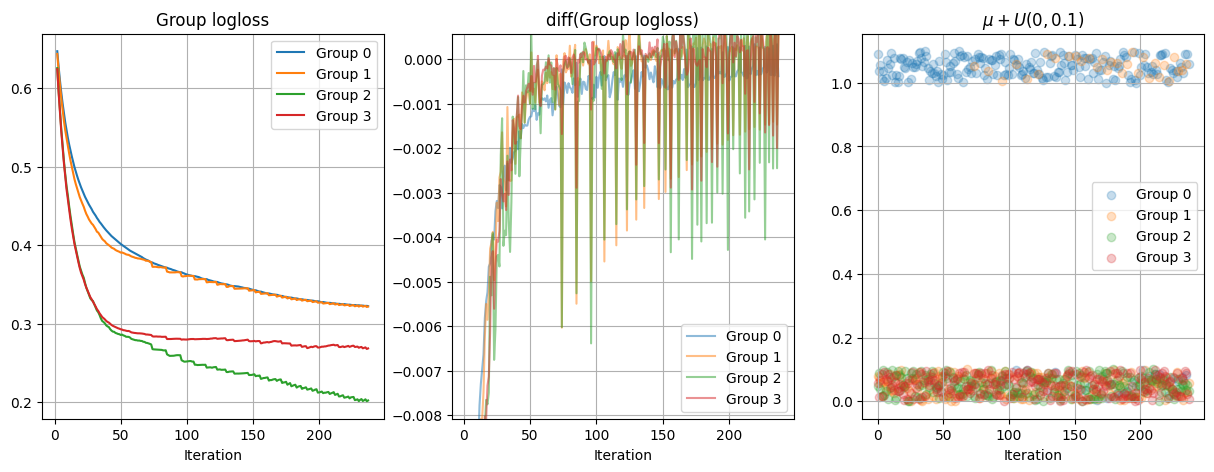

In [30]:
plot_model_result(best_models["M2FGB_test"])

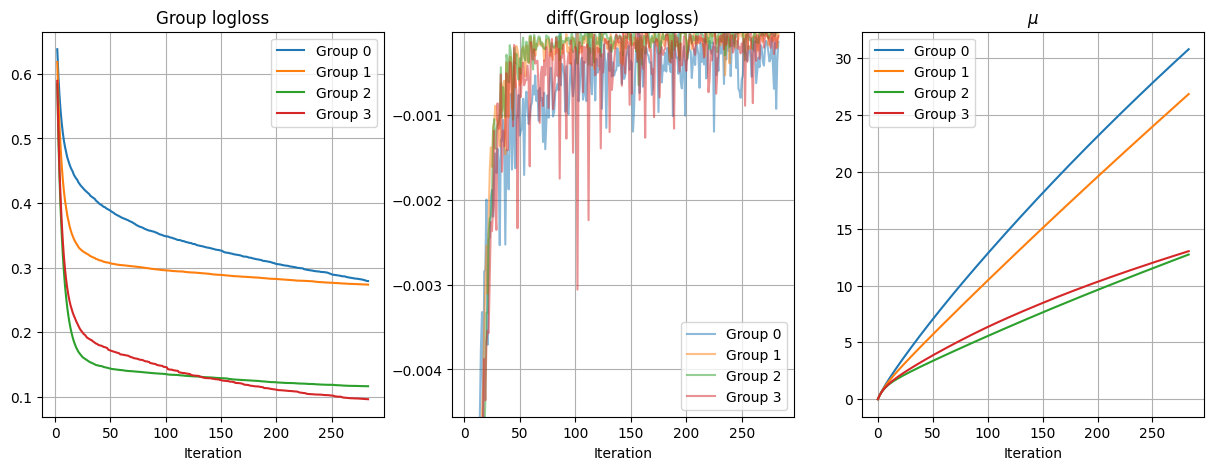

In [31]:
plot_model_result(best_models["M2FGB_grad_test"])

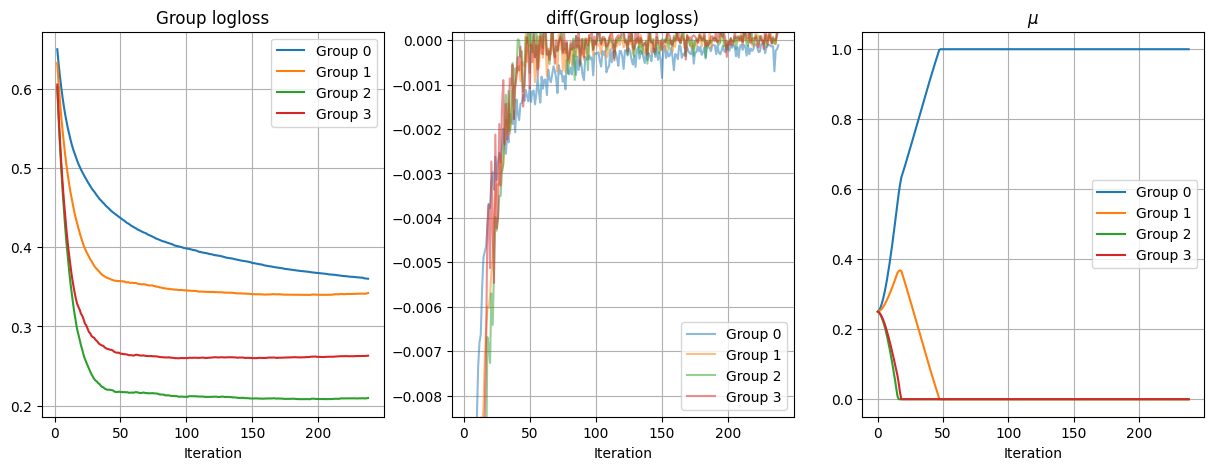

In [32]:
plot_model_result(best_models["M2FGB_grad_norm_test"])

## Hyperparam tuning for performance

In [33]:
scorer = utils.get_combined_metrics_scorer(
    alpha=1, performance_metric="bal_acc", fairness_metric="min_bal_acc"
)

In [34]:
param_spaces = {}
for model_name in ["LGBMClassifier", "FairGBMClassifier"]:
    param_spaces[model_name] = experiments.get_param_spaces(model_name)
    #param_spaces[model_name]["n_estimators"] = {"type" : "int", "low" : 250, "high":250}
    #param_spaces[model_name]["learning_rate"] = {"type" : "float", "low" : 0.1, "high":0.1}

param_spaces["M2FGB_test"] = experiments.get_param_spaces("M2FGB").copy()
param_spaces["M2FGB_grad_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
param_spaces["M2FGB_grad_norm_test"] = experiments.get_param_spaces("M2FGB_grad").copy()
del param_spaces["M2FGB_test"]["fair_weight"]
del param_spaces["M2FGB_grad_test"]["fair_weight"]
del param_spaces["M2FGB_grad_norm_test"]["fair_weight"]

In [37]:
best_params = {}
best_models = {}
results = []
for model_name in ["LGBMClassifier", "FairGBMClassifier", "M2FGB_test", "M2FGB_grad_test", "M2FGB_grad_norm_test"]:
    if model_name == "M2FGB_test":
        def model_(**params):
            return M2FGB_test(random_state=0, **params)
        model_class = model_
    elif model_name == "M2FGB_grad_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient", **params)
        model_class = model_
    elif model_name == "M2FGB_grad_norm_test":
        def model_(**params):
            return M2FGB_test(random_state=0, dual_learning="gradient_norm", **params)
        model_class = model_
    else:
        model_class = experiments.get_model(model_name, random_state=0)

    study = optuna.create_study(direction="maximize")
    objective = lambda trial: run_trial(
        trial,
        scorer,
        X_train,
        Y_train,
        A_train,
        X_val,
        Y_val,
        A_val,
        model_class,
        param_spaces[model_name],
        {"thresh" : 0.5},
    )
    study.optimize(objective, n_trials=100, n_jobs=-1)
    best_params[model_name] = study.best_params.copy()

    model = model_class(**best_params[model_name])
    model.fit(X_train, Y_train, A_train)

    best_models[model_name] = model
    Y_train_pred = model.predict(X_train) > 0.5
    Y_val_pred = model.predict(X_val) > 0.5
    Y_test_pred = model.predict(X_test) > 0.5

    results.append(get_metrics(Y_train, Y_train_pred, A_train))
    results[-1]["set"] = "train"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_val, Y_val_pred, A_val))
    results[-1]["set"] = "val"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_test, Y_test_pred, A_test))
    results[-1]["set"] = "test"
    results[-1]["model"] = model_name


results = pd.DataFrame(results)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Info] Using self-defined objective function


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that me

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encou

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow enco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:4: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:21: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:37: RuntimeWarning: overflow encountered in exp
  predt = 1 / (1 + np.exp(-predt))
/tmp/ipykernel_2216/3179951305.py:234: RuntimeWarning: overflow encountered in exp
  preds_pos = 1 / (1 + np.exp(-log_odds))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accurac

In [38]:
results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))

/tmp/ipykernel_2216/3152775685.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))


bal_acc       roc       eod  min_bal_acc    set  \
set                                                          
test  11  0.810332  0.810332  0.096368     0.781779   test   
      2   0.806321  0.806321  0.185259     0.742278   test   
      14  0.790749  0.790749  0.243550     0.716699   test   
      8   0.790651  0.790651  0.298891     0.696498   test   
      5   0.799505  0.799505  0.410786     0.637066   test   
train 9   0.839636  0.839636  0.148699     0.819089  train   
      0   0.818635  0.818635  0.152545     0.768815  train   
      12  0.799282  0.799282  0.202277     0.733581  train   
      3   0.807685  0.807685  0.360828     0.686382  train   
      6   0.797509  0.797509  0.314585     0.684968  train   
val   13  0.795032  0.795032  0.171845     0.737972    val   
      7   0.797323  0.797323  0.229767     0.731132    val   
      10  0.800619  0.800619  0.224647     0.726179    val   
      1   0.804527  0.804527  0.281714     0.701179    val   
      4   0.790370  0.790370  0.408922     0.644575    val   

                         model  
set                             
test  11       M2FGB_grad_test  
      2         LGBMClassifier  
      14  M2FGB_grad_norm_test  
      8             M2FGB_test  
      5      FairGBMClassifier  
train 9        M2FGB_grad_test  
      0         LGBMClassifier  
      12  M2FGB_grad_norm_test  
      3      FairGBMClassifier  
      6             M2FGB_test  
val   13  M2FGB_grad_norm_test  
      7             M2FGB_test  
      10       M2FGB_grad_test  
      1         LGBMClassifier  
      4      FairGBMClassifier

## Testing new implementation (with fairness and performance)

In [16]:
model = M2FGB_new(n_estimators=100, min_child_weight=1, learning_rate = 0.1, fair_weight = 0.5)
model.fit(X_train, Y_train, A_train)

0.5 1.764177352356872
0.5480203925762754 1.9336103304255745
0.5909242201857077 2.0849902524215422
0.6293647258292395 2.220621991360473
0.663874262116198 2.3423838760760525
0.6948996190675676 2.4518523402408405
0.7243730974428112 2.5505066467955237
0.7509188068911917 2.6406263651876665
0.7733687319958333 2.7217723248782457
0.7950906754820483 2.786924578554663
0.8134752298524763 2.8547171468360775
0.831282649164431 2.8963818299820128
0.8473605229474397 2.9510865255437295
0.8618809212570043 3.001500929190219
0.8749978593867019 3.0359732755927205
0.8868494179702016 3.0764089052609918
0.8975595603800949 3.114763466203068
0.9072397009143909 3.1494411895653744
0.9157855750179281 3.148936930208882
0.9237195333110779 3.1484786710283905
0.9306715250597613 3.161533405598525
0.9369456806257457 3.159271192718248
0.9383328458209795 3.187597817835273
0.9441072179143569 3.212492814614833
0.9433417911634703 3.2060849352566274
0.938499432257053 3.1806346176005538
0.9372749469473758 3.191856423816876
0.9

M2FGB_new(n_estimators=100)

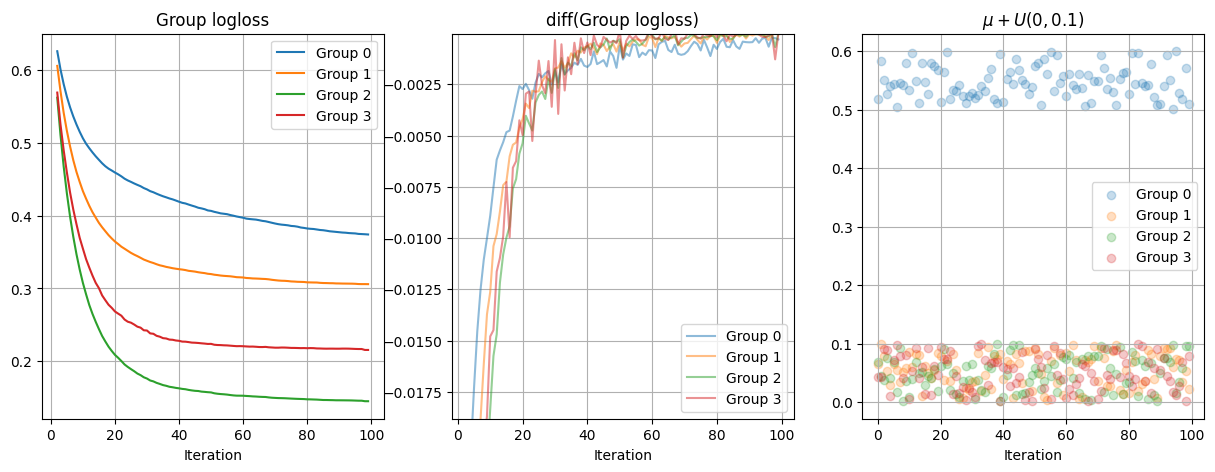

In [17]:
plot_model_result(model)

In [18]:
model = M2FGB_new(n_estimators=100, min_child_weight=1, learning_rate = 0.1, fair_weight = 0.0)
model.fit(X_train, Y_train, A_train)

0.5 0.0
0.5492309607667669 0.0
0.593247662598576 0.0
0.632650957009156 0.0
0.6680598219501024 0.0
0.6998621905248862 0.0
0.7284872950896144 0.0
0.7542747637979296 0.0
0.7773212364223185 0.0
0.7983619581362088 0.0
0.8171469595611773 0.0
0.834902514078885 0.0
0.8486409465293038 0.0
0.8632991942689318 0.0
0.8743103056785386 0.0
0.8865718232337527 0.0
0.8956593609289382 0.0
0.9054655655128737 0.0
0.9143335380463041 0.0
0.9223536931255966 0.0
0.9296075989978637 0.0
0.9361688726010856 0.0
0.9421039802234286 0.0
0.9398455442884067 0.0
0.9453716908556921 0.0
0.9402680333685719 0.0
0.9361252191410112 0.0
0.9327614915926993 0.0
0.9383508087060182 0.0
0.9397026618708494 0.0
0.9414908382683336 0.0
0.94198651304307 0.0
0.9455143258192152 0.0
0.9503129312353975 0.0
0.9512128533434068 0.0


KeyboardInterrupt: 

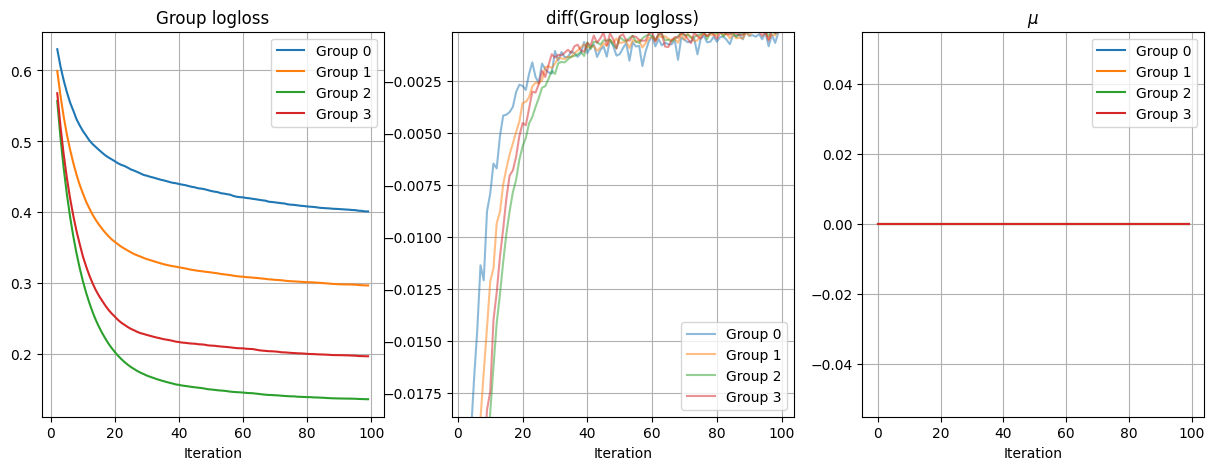

In [42]:
plot_model_result(model)

In [19]:
model = M2FGB_new(n_estimators=100, min_child_weight=1, learning_rate = 0.1, fair_weight = 1)
model.fit(X_train, Y_train, A_train)

0.5 3.528354704713744
0.5494112038371144 3.877035211762249
0.5935388895752668 4.188431466926928
0.631672628364836 4.457530180259931
0.6672910978287514 4.7088793688753485
0.6979497157711964 4.925228326589842
0.726896333396692 5.129496195558777
0.7529447530708905 5.287202615297326
0.7758321401305969 5.286473222943067
0.7970889270267395 5.422331352091618
0.8162982423703625 5.57199569334812
0.8336068886172874 5.681334303629388
0.8492116321367013 5.780500438486103
0.862775265953812 5.728027297047223
0.8759031676401177 5.83815528635046
0.8876553847273297 5.803696951389831
0.8980996632297118 5.88573189321752
0.9077764362886668 5.986084823666223
0.9163193279788161 6.0737669182362595
0.9242905423856734 6.153653278113131
0.9315946572944679 6.075592247078629
0.9378525292337292 6.152610659734429
0.9437655294053149 6.169567770944115
0.9491726451920566 6.085246989554499
0.9576317467839304 6.157774190862307
0.9616784562464327 6.166303517014686
0.9582551696924616 6.230620670915314
0.9622245056052484 6

M2FGB_new(fair_weight=1, n_estimators=100)

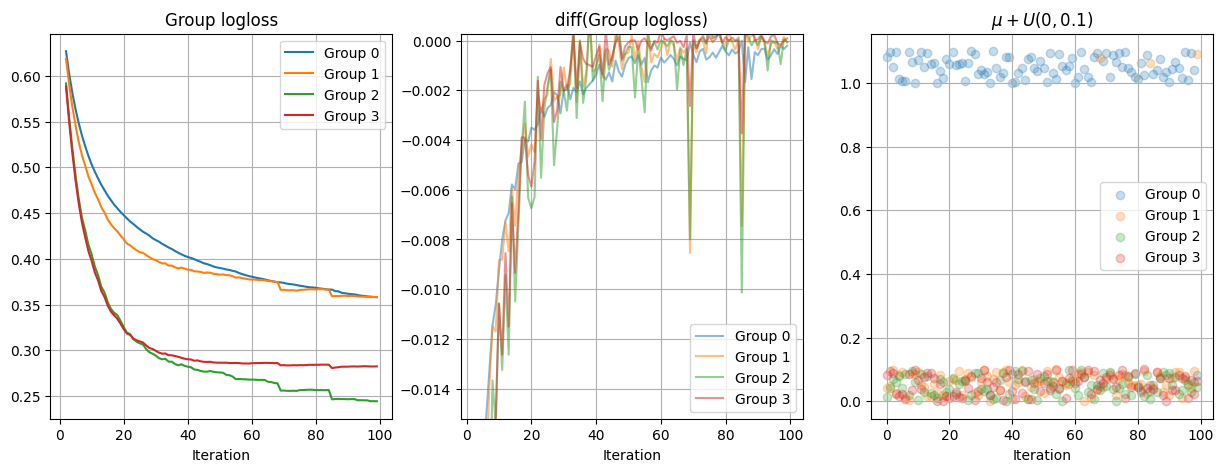

In [20]:
plot_model_result(model)

In [45]:
model = M2FGB_test(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient", multiplier_learning_rate = 0.1)
model.fit(X_train, Y_train, A_train)

M2FGB_test(dual_learning='gradient', n_estimators=500)

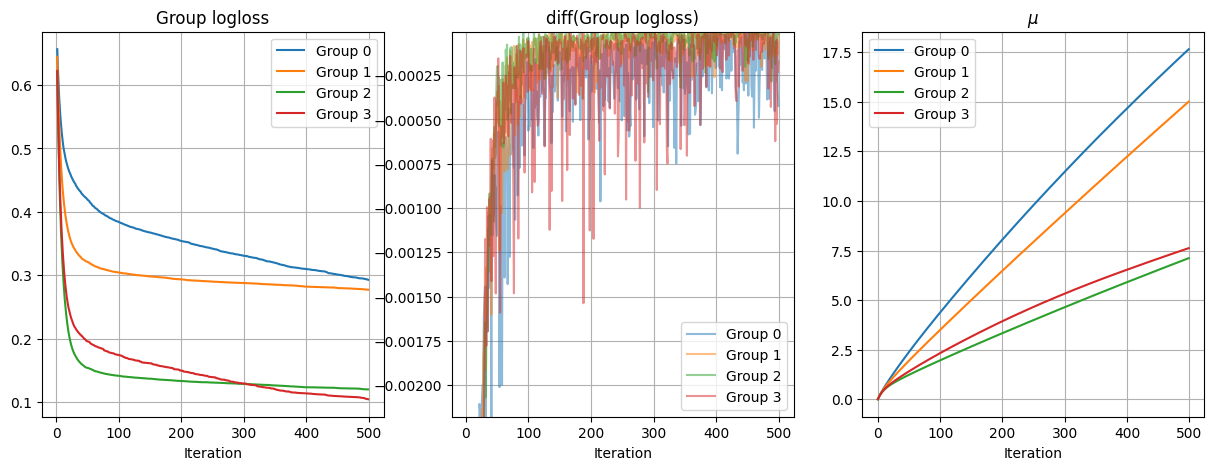

In [46]:
plot_model_result(model)

In [47]:
model = M2FGB_new(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient", multiplier_learning_rate = 0.1, fair_weight = 0.95)
model.fit(X_train, Y_train, A_train)

M2FGB_new(dual_learning='gradient', fair_weight=0.95, n_estimators=500)

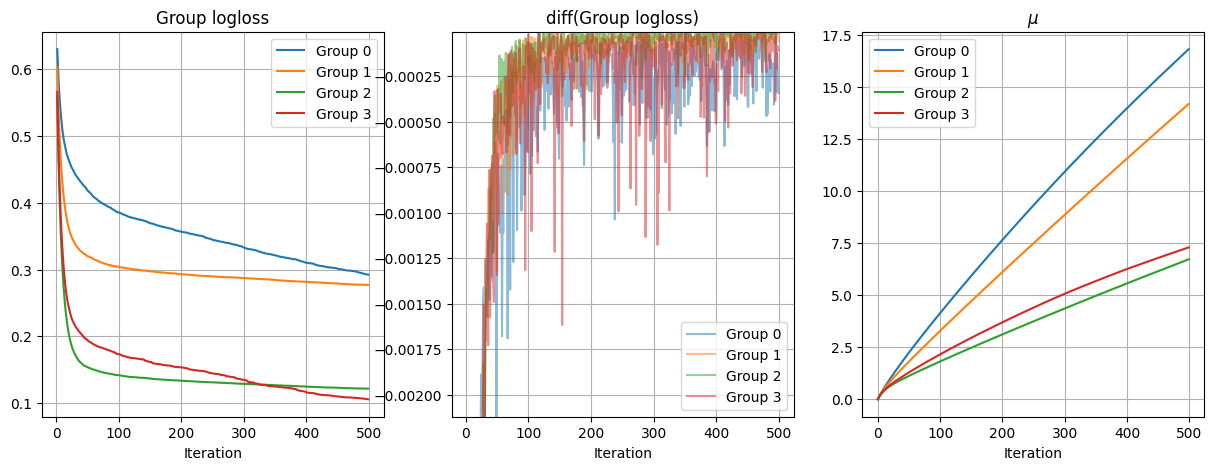

In [48]:
plot_model_result(model)

In [55]:
model = M2FGB_new(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient_norm", multiplier_learning_rate = 0.1)
model.fit(X_train, Y_train, A_train)

M2FGB_new(dual_learning='gradient_norm', n_estimators=500)

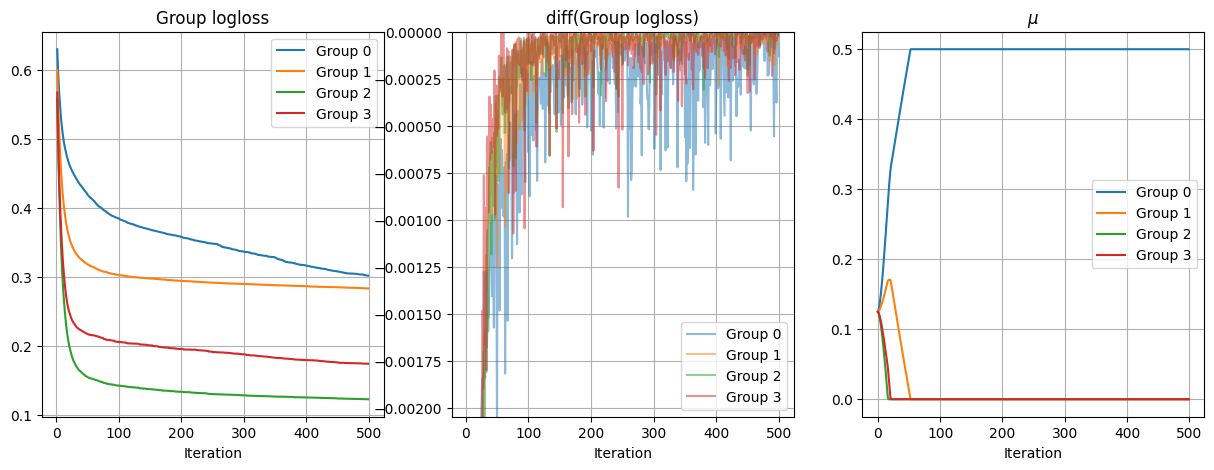

In [56]:
plot_model_result(model)

In [53]:
model = M2FGB_new(n_estimators=500, min_child_weight=1, learning_rate = 0.1, dual_learning = "gradient_norm", multiplier_learning_rate = 0.1, fair_weight = 0.95)
model.fit(X_train, Y_train, A_train)

M2FGB_new(dual_learning='gradient_norm', fair_weight=0.95, n_estimators=500)

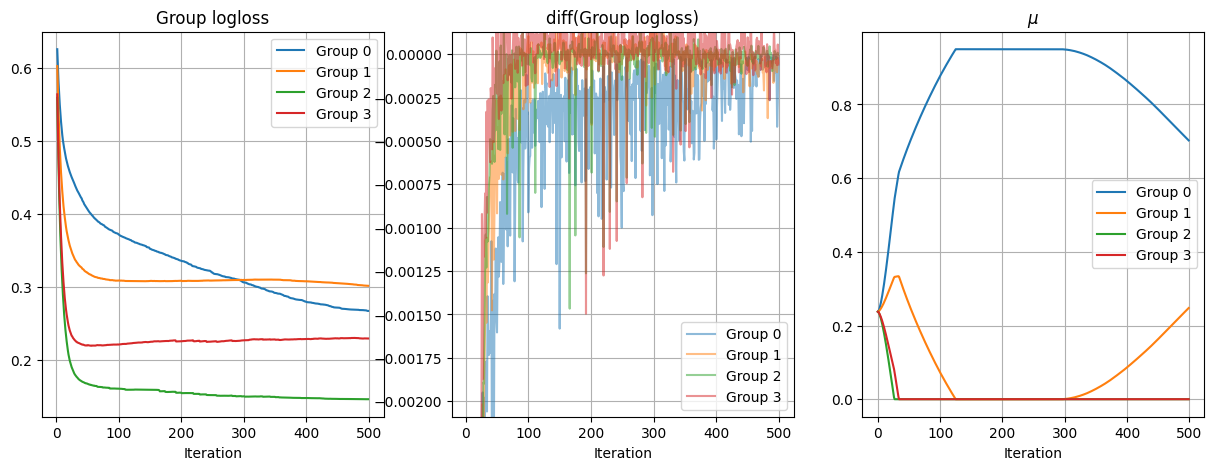

In [54]:
plot_model_result(model)

## Hyper-param tuning for new implementation

In [57]:
param_spaces = {}
for model_name in ["LGBMClassifier", "FairGBMClassifier"]:
    param_spaces[model_name] = experiments.get_param_spaces(model_name)
    #param_spaces[model_name]["n_estimators"] = {"type" : "int", "low" : 250, "high":250}
    #param_spaces[model_name]["learning_rate"] = {"type" : "float", "low" : 0.1, "high":0.1}

param_spaces["M2FGB_new"] = experiments.get_param_spaces("M2FGB").copy()
param_spaces["M2FGB_grad_new"] = experiments.get_param_spaces("M2FGB_grad").copy()
param_spaces["M2FGB_grad_norm_new"] = experiments.get_param_spaces("M2FGB_grad").copy()


param_spaces["M2FGB_new"]["fair_weight"] = {"type": "float", "low": 0, "high": 1}
param_spaces["M2FGB_grad_new"]["fair_weight"] = {"type": "float", "low": 0, "high": 1}
param_spaces["M2FGB_grad_norm_new"]["fair_weight"] = {"type": "float", "low": 0, "high": 1}


### Fair

In [58]:
scorer = utils.get_combined_metrics_scorer(
    alpha=0., performance_metric="bal_acc", fairness_metric="min_bal_acc"
)

In [60]:
best_params = {}
best_models = {}
results = []
for model_name in ["LGBMClassifier", "FairGBMClassifier", "M2FGB_grad_new", "M2FGB_grad_norm_new"]:
    if model_name == "M2FGB_new":
        def model_(**params):
            return M2FGB_new(random_state=0, **params)
        model_class = model_
    elif model_name == "M2FGB_grad_new":
        def model_(**params):
            return M2FGB_new(random_state=0, dual_learning="gradient", **params)
        model_class = model_
    elif model_name == "M2FGB_grad_norm_new":
        def model_(**params):
            return M2FGB_new(random_state=0, dual_learning="gradient_norm", **params)
        model_class = model_
    else:
        model_class = experiments.get_model(model_name, random_state=0)

    study = optuna.create_study(direction="maximize")
    objective = lambda trial: run_trial(
        trial,
        scorer,
        X_train,
        Y_train,
        A_train,
        X_val,
        Y_val,
        A_val,
        model_class,
        param_spaces[model_name],
        {"thresh" : 0.5},
    )
    study.optimize(objective, n_trials=20, n_jobs=-1)
    best_params[model_name] = study.best_params.copy()

    model = model_class(**best_params[model_name])
    model.fit(X_train, Y_train, A_train)

    best_models[model_name] = model
    Y_train_pred = model.predict(X_train) > 0.5
    Y_val_pred = model.predict(X_val) > 0.5
    Y_test_pred = model.predict(X_test) > 0.5

    results.append(get_metrics(Y_train, Y_train_pred, A_train))
    results[-1]["set"] = "train"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_val, Y_val_pred, A_val))
    results[-1]["set"] = "val"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_test, Y_test_pred, A_test))
    results[-1]["set"] = "test"
    results[-1]["model"] = model_name


results = pd.DataFrame(results)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Wa

In [61]:
results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))

/tmp/ipykernel_2216/3152775685.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))


bal_acc       roc       eod  min_bal_acc    set  \
set                                                          
test  8   0.805489  0.805489  0.154857     0.756274   test   
      11  0.811751  0.811751  0.193227     0.744208   test   
      2   0.807213  0.807213  0.194555     0.742278   test   
      5   0.786238  0.786238  0.216294     0.735711   test   
train 6   0.818132  0.818132  0.134043     0.798642  train   
      9   0.837916  0.837916  0.206346     0.795414  train   
      0   0.821459  0.821459  0.148999     0.775280  train   
      3   0.801150  0.801150  0.148887     0.762345  train   
val   7   0.797659  0.797659  0.221113     0.728066    val   
      4   0.773070  0.773070  0.173469     0.723588    val   
      10  0.799649  0.799649  0.239046     0.717453    val   
      1   0.793685  0.793685  0.239311     0.703066    val   

                        model  
set                            
test  8        M2FGB_grad_new  
      11  M2FGB_grad_norm_new  
      2        LGBMClassifier  
      5     FairGBMClassifier  
train 6        M2FGB_grad_new  
      9   M2FGB_grad_norm_new  
      0        LGBMClassifier  
      3     FairGBMClassifier  
val   7        M2FGB_grad_new  
      4     FairGBMClassifier  
      10  M2FGB_grad_norm_new  
      1        LGBMClassifier

In [66]:
best_params

{'LGBMClassifier': {'num_leaves': 338,
  'n_estimators': 316,
  'min_child_samples': 30,
  'max_depth': 9,
  'reg_lambda': 5.807676407589221,
  'learning_rate': 0.4782232744383296},
 'FairGBMClassifier': {'n_estimators': 54,
  'min_child_samples': 5,
  'max_depth': 5,
  'reg_lambda': 0.0013225829554102788,
  'learning_rate': 0.2078219259901,
  'multiplier_learning_rate': 0.005927219516879034,
  'constraint_fnr_tolerance': 0.005272675392708841},
 'M2FGB_new': {'min_child_weight': 0.2957301921217608,
  'n_estimators': 92,
  'learning_rate': 0.4763733352292169,
  'max_depth': 9,
  'reg_lambda': 0.6756375522173672,
  'fair_weight': 0.9258948719088376},
 'M2FGB_grad_new': {'min_child_weight': 17.513678978600975,
  'n_estimators': 324,
  'learning_rate': 0.1888304188819026,
  'max_depth': 9,
  'reg_lambda': 0.011187082298803169,
  'fair_weight': 0.917052830725769,
  'multiplier_learning_rate': 0.4839891247516093},
 'M2FGB_grad_norm_new': {'min_child_weight': 1.8236037875797566,
  'n_estimato

### Performance

In [67]:
scorer = utils.get_combined_metrics_scorer(
    alpha=1., performance_metric="bal_acc", fairness_metric="min_bal_acc"
)

In [ ]:
best_params = {}
best_models = {}
results = []
for model_name in ["LGBMClassifier", "FairGBMClassifier", "M2FGB_new", "M2FGB_grad_new", "M2FGB_grad_norm_new"]:
    if model_name == "M2FGB_new":
        def model_(**params):
            return M2FGB_new(random_state=0, **params)
        model_class = model_
    elif model_name == "M2FGB_grad_new":
        def model_(**params):
            return M2FGB_new(random_state=0, dual_learning="gradient", **params)
        model_class = model_
    elif model_name == "M2FGB_grad_norm_new":
        def model_(**params):
            return M2FGB_new(random_state=0, dual_learning="gradient_norm", **params)
        model_class = model_
    else:
        model_class = experiments.get_model(model_name, random_state=0)

    study = optuna.create_study(direction="maximize")
    objective = lambda trial: experiments.run_trial(
        trial,
        scorer,
        X_train,
        Y_train,
        A_train,
        X_val,
        Y_val,
        A_val,
        model_class,
        param_spaces[model_name],
        {"thresh" : 0.5},
    )
    study.optimize(objective, n_trials=100, n_jobs=-1)
    best_params[model_name] = study.best_params.copy()

    model = model_class(**best_params[model_name])
    if model_name == "LGBMClassifier":
        model.fit(X_train, Y_train)
    elif model_name == "FairGBMClassifier":
        model.fit(X_train, Y_train, constraint_group = A_train)
    else:
        model.fit(X_train, Y_train, A_train)

    best_models[model_name] = model
    Y_train_pred = model.predict(X_train) > 0.5
    Y_val_pred = model.predict(X_val) > 0.5
    Y_test_pred = model.predict(X_test) > 0.5

    results.append(get_metrics(Y_train, Y_train_pred, A_train))
    results[-1]["set"] = "train"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_val, Y_val_pred, A_val))
    results[-1]["set"] = "val"
    results[-1]["model"] = model_name
    results.append(get_metrics(Y_test, Y_test_pred, A_test))
    results[-1]["set"] = "test"
    results[-1]["model"] = model_name


results = pd.DataFrame(results)

In [69]:
results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))

/tmp/ipykernel_24/3152775685.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby("set").apply(lambda d : d.sort_values(["min_bal_acc"], ascending = False))


bal_acc       roc       eod  min_bal_acc    set  \
set                                                          
test  5   0.807433  0.807433  0.135062     0.787338   test   
      2   0.808009  0.808009  0.154857     0.765927   test   
      8   0.807996  0.807996  0.147017     0.758205   test   
      14  0.810357  0.810357  0.197211     0.744208   test   
      11  0.807984  0.807984  0.186747     0.738417   test   
train 9   0.818810  0.818810  0.091852     0.807376  train   
      3   0.819499  0.819499  0.220530     0.801423  train   
      6   0.834445  0.834445  0.216170     0.783043  train   
      0   0.811522  0.811522  0.138616     0.768972  train   
      12  0.812894  0.812894  0.148890     0.763491  train   
val   7   0.801201  0.801201  0.203180     0.740566    val   
      4   0.799081  0.799081  0.184717     0.713915    val   
      10  0.803583  0.803583  0.274647     0.706840    val   
      1   0.801267  0.801267  0.267580     0.701179    val   
      13  0.800860  0.800860  0.274647     0.701179    val   

                        model  
set                            
test  5     FairGBMClassifier  
      2        LGBMClassifier  
      8             M2FGB_new  
      14  M2FGB_grad_norm_new  
      11       M2FGB_grad_new  
train 9        M2FGB_grad_new  
      3     FairGBMClassifier  
      6             M2FGB_new  
      0        LGBMClassifier  
      12  M2FGB_grad_norm_new  
val   7             M2FGB_new  
      4     FairGBMClassifier  
      10       M2FGB_grad_new  
      1        LGBMClassifier  
      13  M2FGB_grad_norm_new

In [70]:
best_params

{'LGBMClassifier': {'num_leaves': 22,
  'n_estimators': 411,
  'min_child_samples': 85,
  'max_depth': 6,
  'reg_lambda': 4.578496665541483,
  'learning_rate': 0.07913926072326208},
 'FairGBMClassifier': {'n_estimators': 69,
  'min_child_samples': 37,
  'max_depth': 6,
  'reg_lambda': 0.007050230870557439,
  'learning_rate': 0.24446121172243396,
  'multiplier_learning_rate': 0.00642101206218857,
  'constraint_fnr_tolerance': 0.02705326162657464},
 'M2FGB_new': {'min_child_weight': 3.054656646878516,
  'n_estimators': 339,
  'learning_rate': 0.2994424531699183,
  'max_depth': 7,
  'reg_lambda': 0.0314781739974427,
  'fair_weight': 0.552239334916739},
 'M2FGB_grad_new': {'min_child_weight': 0.0010132322735095746,
  'n_estimators': 179,
  'learning_rate': 0.1310097418208018,
  'max_depth': 7,
  'reg_lambda': 0.0029305604496255933,
  'fair_weight': 0.42488627476026425,
  'multiplier_learning_rate': 0.04033148420836875},
 'M2FGB_grad_norm_new': {'min_child_weight': 0.04067121496905835,
  'n